In [2]:
import numpy as np
import matplotlib.pyplot as plt
from library.snr import optimal_snr, approx_snr
from library.lisa_psd import noise_psd_AE, S_gal_response
from library.lisa_response_fastGB import tdi_AE_fastGB, tdi_AE_fastGB_multi
from pycbc.psd.analytical_space import averaged_response_lisa_tdi
from scipy.constants import c
from tqdm import tqdm

/home/alice/miniforge3/envs/gwpy_env/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [3]:
filepath = "/home/alice/catalog_binaries/catalogue_interaction_WDWD_processed.hdf5"

In [4]:
import h5py

with h5py.File(filepath, "r") as f:
    print(list(f.keys()))


['Binaries', 'Metadata']


In [5]:
with h5py.File(filepath, "r") as f:
    def print_structure(name, obj):
        print(name)

    f.visititems(print_structure)
    

Binaries
Binaries/Amplitude
Binaries/ChirpMassSSBFrame
Binaries/Declination
Binaries/Eccentricity
Binaries/GW22FrequencyDerivativeSourceFrame
Binaries/GW22FrequencySSBFrame
Binaries/GW22FrequencySourceFrame
Binaries/InclinationAngle
Binaries/LuminosityDistance
Binaries/MassRatio
Binaries/OrbitalFrequencySSBFrame
Binaries/OrbitalFrequencySourceFrame
Binaries/PolarisationAngle
Binaries/PrimaryMassSSBFrame
Binaries/PrimaryMassSourceFrame
Binaries/Redshift
Binaries/RightAscension
Binaries/SecondaryMassSSBFrame
Binaries/SecondaryMassSourceFrame
Binaries/TimeCoalescencePetersSSBFrame
Binaries/TimeCoalescencePetersSourceFrame
Binaries/TimeReferenceSSBFrame
Binaries/TotalMassSSBFrame
Binaries/TrueAnomaly
Metadata


for fastGB: it should be everything in the source frame
 frequency (Hz), fdot (Hz**2), amplitude (strain), ecliptic latitude, ecliptic longitude, polarization angle, inclination, initial phase (all inradians)
 T obs (seconds),  N (number of frequency bins to generate waveform, power of 2),  delta_t (sampling time in seconds, usually 5 s)

 GW22FrequencySourceFrame

 GW22FrequencyDerivativeSourceFrame
 Amplitude

 Declination --> ecliptic latitude

 RightAscension --> ecliptic longitude

 PolarisationAngle

 InclinationAngle

 missing initial phase (set it to random)

In [6]:
keys = ["GW22FrequencySourceFrame", "GW22FrequencyDerivativeSourceFrame", "Amplitude", "Declination", "RightAscension", "PolarisationAngle", "InclinationAngle", "SecondaryMassSSBFrame", "PrimaryMassSSBFrame", "TotalMassSSBFrame"]

with h5py.File(filepath, "r") as f:
    binaries = f["Binaries"]

    param_binaries = {name: binaries[name][:] for name in keys}
    
for key, val in param_binaries.items():
    print(f"{key:35} shape={val.shape}, dtype={val.dtype}")

GW22FrequencySourceFrame            shape=(15539324,), dtype=float64
GW22FrequencyDerivativeSourceFrame  shape=(15539324,), dtype=float64
Amplitude                           shape=(15539324,), dtype=float64
Declination                         shape=(15539324,), dtype=float64
RightAscension                      shape=(15539324,), dtype=float64
PolarisationAngle                   shape=(15539324,), dtype=float64
InclinationAngle                    shape=(15539324,), dtype=float64
SecondaryMassSSBFrame               shape=(15539324,), dtype=float64
PrimaryMassSSBFrame                 shape=(15539324,), dtype=float64
TotalMassSSBFrame                   shape=(15539324,), dtype=float64


In [7]:
import astropy.units as u
from astropy.coordinates import SkyCoord, GeocentricTrueEcliptic

# to convert from equatorial to ecliptic coordinates

ra_rad = param_binaries["RightAscension"]  
dec_rad = param_binaries["Declination"]    

c = SkyCoord(ra=ra_rad * u.rad,
             dec=dec_rad * u.rad,
             frame='icrs')

ecl = c.transform_to(GeocentricTrueEcliptic())

lam = ecl.lon.to(u.rad).value
bet = ecl.lat.to(u.rad).value

param_binaries["EclipticLatitude"] = bet
param_binaries["EclipticLongitude"] = lam

del param_binaries["RightAscension"]
del param_binaries["Declination"]


Plot some distribution of the parameters of the binaries

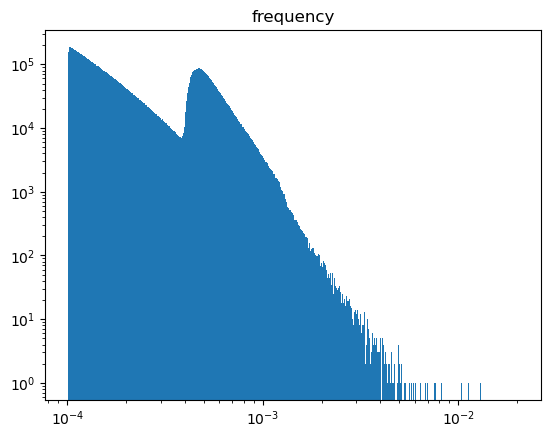

In [8]:
plt.hist(param_binaries["GW22FrequencySourceFrame"], bins=10000)
plt.yscale("log")
plt.title("frequency")
plt.xscale("log")
#plt.grid(axis = 'y',color='lightgrey')

Min M tot: 0.3581852597061732
Max M tot: 2.3683269023895264


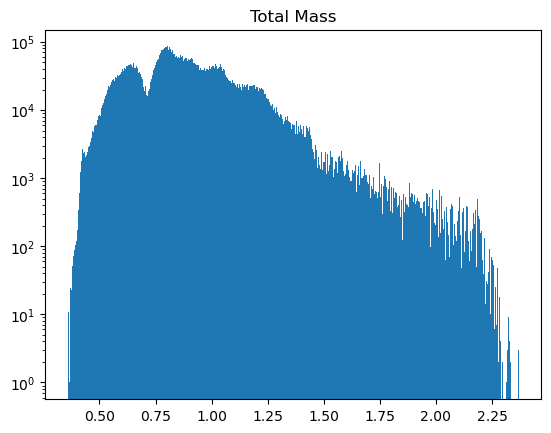

In [9]:
plt.hist(param_binaries["TotalMassSSBFrame"], bins=1000)
plt.yscale("log")
plt.title("Total Mass")
#plt.xscale("log")
print("Min M tot:", np.min(param_binaries["TotalMassSSBFrame"]))
print("Max M tot:", np.max(param_binaries["TotalMassSSBFrame"]))

Text(0.5, 1.0, 'Amplitude')

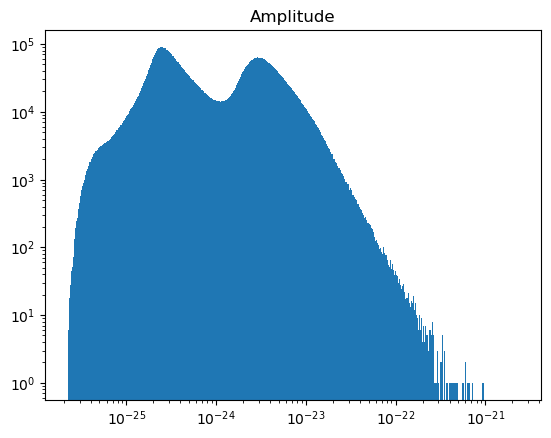

In [10]:
bins = np.logspace(np.log10(param_binaries["Amplitude"].min()), np.log10(param_binaries["Amplitude"].max()), 1000)
plt.hist(param_binaries["Amplitude"], bins = bins)
plt.yscale("log")
plt.xscale("log")
plt.title("Amplitude")
#plt.grid(axis = 'y',color='lightgrey')

-1.0687275141712523e-13
1.0245330850498006e-13
2.093260599221054e-15
Most populated bin index: 51
Count: 15539056.0 99.99827534325175 % of all sources
Bin range: -1.16460856851549e-16 to 1.9767997423695048e-15


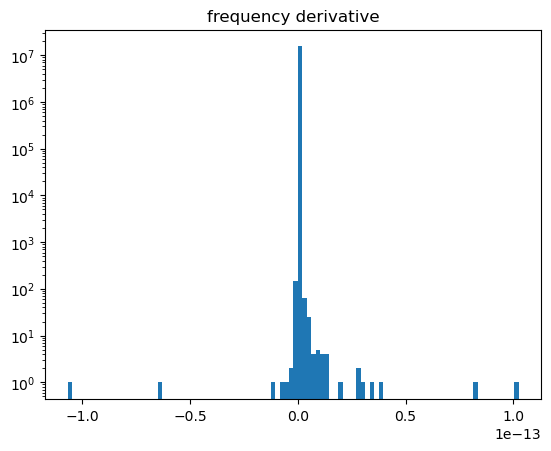

In [11]:
counts, bin_edges, patches = plt.hist(param_binaries["GW22FrequencyDerivativeSourceFrame"], bins=100)
plt.yscale("log")
plt.title("frequency derivative")
#plt.grid(axis = 'y',color='lightgrey')
#print(counts)

print(param_binaries["GW22FrequencyDerivativeSourceFrame"].min())

print(param_binaries["GW22FrequencyDerivativeSourceFrame"].max())

bin_widths = bin_edges[1] - bin_edges[0]
print(bin_widths)
max_bin_index = np.argmax(counts)
print("Most populated bin index:", max_bin_index)
print("Count:", counts[max_bin_index], counts[max_bin_index]/len(param_binaries["Amplitude"])*100, "% of all sources")
print("Bin range:",
      bin_edges[max_bin_index],
      "to",
      bin_edges[max_bin_index + 1])


In [12]:
T_obs = 4*365*24*3600
fdots = param_binaries["GW22FrequencyDerivativeSourceFrame"][4000:5000]
deltafs = np.maximum(1/T_obs, np.abs(fdots)*T_obs)
deltaf = 0.1e-13 *T_obs
required_bins = deltafs *T_obs
#print(required_bins)


In [13]:
from library.lisa_response_fastGB import tdi_AE_fastGB
from library.lisa_psd import noise_psd_AE
import scipy.constants as constants

Rough estimate of the psd of a source:

Maggiore (eq. 7.9): $\frac{1}{2} S_h T_{obs} = \langle | \tilde{h(f)}|^2 \rangle $

$ \tilde{h(f)} =  R(f) \tilde{h(f)}$

LISA response (Robson et al. eq. 9): $ R(f) = \frac{3}{20} \frac{1}{(1 + 0.6(f/f_\ast)^2)} $, $ f_\ast  = c/(2 \pi L)$

Source PSD (Robson et al. eq. 16): $ \langle | \tilde{h(f)}|^2 \rangle = 4/5 R(f) A^2(f) $

$ S_h = 2 \Delta f \frac{4}{5} R(f) A^2(f) $

Other option (Robson et al. eq. 19): $ S_h(f) = A^2(f)/(2T_{obs}) $

In [14]:
def process_catalog_batches(catalog, T_obs,  delta_t, tdi,  batch_size, output_file = 'galactic_binaries_waveforms.hdf5', snr_preselection = 0.5, verbose=True):
    """
    Function to process the catalog in batches

    Parameters:
    ------------------
    catalog: contains binaries parameters
    T_obs: in s
    delta_t: sampling time in s
    batch_size: 
    output_file: name of output file
    safety_fctr: safety factor when excluding sources based on their SNR (to avoid waveform calculation)
    """
    
    n_tot = len(catalog["Amplitude"])
    n_batches = int(np.ceil(n_tot/batch_size))
    df = 1/T_obs

    if verbose:
        print(f"Processing {n_tot} sources")
        print(f"Batches: {n_batches} batches with {batch_size} sources")
    
    # Create different N values to assign depending on the required N (depends on the fdot)

    N_values = {
    "small": 8,
    "medium": 32,
    "large": 128
    }


    with h5py.File(output_file, 'w') as f:

        # This creates a dataset for all sources, where I save the waveforms and useful parameters of each batch. Save them in buckets of different Ns to save space
        # do NOT store individual PSDs 

        f.create_group('meta')
        f['meta'].create_dataset('f0', shape=(n_tot,), dtype='float64')
        f['meta'].create_dataset('fdot', shape=(n_tot,), dtype='float64')
        f['meta'].create_dataset('Ampl', shape=(n_tot,), dtype='float64')
        

        f.create_dataset('source_psd_estimate', shape=(n_tot,), dtype='float64')

        for bname, N in N_values.items():
            grp = f.create_group(bname)
            grp.create_dataset('indices', shape=(0,), maxshape=(None,), dtype='int') # to keep track of the source in the whole catalog
            grp.create_dataset('A', shape=(0, N), maxshape=(None, N), dtype='complex128')
            grp.create_dataset('E', shape=(0, N), maxshape=(None, N), dtype='complex128')
            grp.create_dataset('fr', shape=(0, N), maxshape=(None, N), dtype='float64')
            grp.create_dataset('ecliptic_lat', shape=(0,), maxshape=(None,), dtype='float64')
            grp.create_dataset('ecliptic_lon', shape=(0,), maxshape=(None,), dtype='float64')


        # f.create_dataset('psd_instr', shape=(n_tot, f_length), dtype='float64')
    
        # Store observational parameters as attributes
        f.attrs['T_obs'] = T_obs
        f.attrs['N_values'] = list(N_values.values())
        f.attrs['delta_t'] = delta_t

        # Process the batch
        for i in tqdm(range(n_batches), desc="Processing batches", disable=not verbose):
            
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, n_tot)
            current_batch_size = end_idx - start_idx
            
            if verbose:
                print(f"\nBatch {i+1}/{n_batches}: sources [{start_idx}:{end_idx}]")
            
            # Extract this batch from the full catalog
            # Assign random phases phi0
            phi0 = np.random.uniform(0, 2*np.pi, current_batch_size)

            batch_params = np.column_stack([
                catalog['GW22FrequencySourceFrame'][start_idx:end_idx],
                catalog['GW22FrequencyDerivativeSourceFrame'][start_idx:end_idx],
                catalog['Amplitude'][start_idx:end_idx],
                catalog['EclipticLatitude'][start_idx:end_idx],
                catalog['EclipticLongitude'][start_idx:end_idx],
                catalog['PolarisationAngle'][start_idx:end_idx],
                catalog['InclinationAngle'][start_idx:end_idx],
                phi0
            ])
            
            f['meta/f0'][start_idx:end_idx] = batch_params[:, 0]
            f['meta/fdot'][start_idx:end_idx] = batch_params[:, 1]
            f['meta/Ampl'][start_idx:end_idx] = batch_params[:, 2]
            
            
            # Rough estimation of the SNR of sources to avoid computing the waveform of already weak sources
            # For weak sources, compute the estimated PSD and store it (it will contribute to the background)
            fdot = batch_params[:, 1]
            f0 = batch_params[:,0]
            amp = batch_params[:,2]

            h_c = (16 /5 * T_obs)**(1/2) * f0 * amp
            SNR_approx = approx_snr(h_c, f0)

            psd_estimate = h_c**2 / f0 # no response yet
            psd_estimate_response = psd_estimate * 1.5*S_gal_response(f0, L = 2.5e9/constants.c, tdi = tdi)

            f['source_psd_estimate'][start_idx:end_idx] = psd_estimate_response

            # Mask the loud sources (possibly resolvable) using a SNR threshold. Skipped sources have None instead of the waveform

            loud_sources_mask = SNR_approx > snr_preselection
            weak_sources_mask = ~loud_sources_mask
            print(f"Loud sources (SNR > {snr_preselection}): {loud_sources_mask.sum()}")
            print(f"Weak sources (SNR <= {snr_preselection}): {weak_sources_mask.sum()}")
            # Select N based on fdot to compute the waveform with FastGB for the loud sources
            
            delta_f = np.maximum(1 / T_obs, np.abs(fdot) * T_obs)
            required_bins = delta_f * T_obs   

            bucket = np.full(len(f0), 'skip', dtype='U10') # initialize the bukcets with all 'skip': weak source will keep 'skip' and will be skipped when doing FastGB

            bucket[(required_bins < 9) & loud_sources_mask] = "small"
            bucket[(required_bins >= 9) & (required_bins < 33) & loud_sources_mask] = "medium"
            bucket[(required_bins >= 33) & loud_sources_mask] = "large"

            # process each bucket individually
            for bname, N in N_values.items():

                mask = (bucket == bname)
                if not np.any(mask):
                    continue

                params_sub = batch_params[mask]
                idxs = np.where(mask)[0]
                global_idxs = start_idx + idxs

                A_sub, E_sub, kmin, fr_sub = tdi_AE_fastGB_multi(
                    params_sub,
                    delta_t=delta_t,
                    T_obs=T_obs,
                    N=N
                )

                ecliptic_lat_sub = batch_params[mask, 3]  
                ecliptic_lon_sub = batch_params[mask, 4]

                grp = f[bname]
                old = grp['indices'].shape[0]
                new = old + len(global_idxs)
                
                grp['indices'].resize((new,))
                grp['A'].resize((new, N))
                grp['E'].resize((new, N))
                grp['fr'].resize((new, N))
                grp['ecliptic_lat'].resize((new,))  
                grp['ecliptic_lon'].resize((new,))

                grp['indices'][old:new] = global_idxs
                grp['A'][old:new] = A_sub
                grp['E'][old:new] = E_sub
                grp['fr'][old:new] = fr_sub
                grp['ecliptic_lat'][old:new] = ecliptic_lat_sub  
                grp['ecliptic_lon'][old:new] = ecliptic_lon_sub

                # Clear memory
                del A_sub, E_sub, fr_sub, ecliptic_lat_sub, ecliptic_lon_sub
                

        if verbose:
            print(f"Saved {n_tot} waveforms sources to {output_file}")
            print(f"File size: {f.id.get_filesize() / (1024**3):.2f} GB")
        
    return output_file

Check how close the approximate SNR and PSD estimation are to the actual values computed from waveform 

SNR approximate: 1.5188678699137458e-05
SNR accurate: 0.0006107223195475251


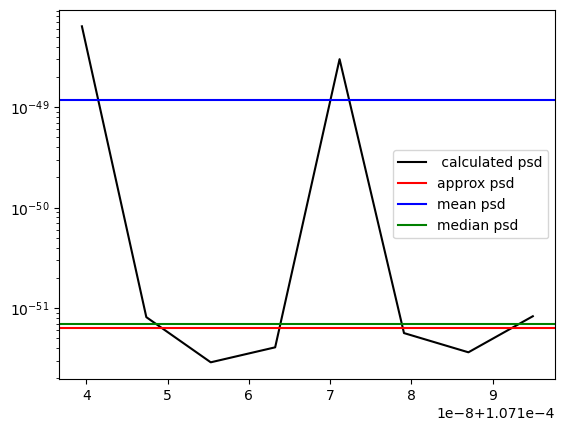

In [15]:
i = 0
f0 = param_binaries["GW22FrequencySourceFrame"][i]
amp = param_binaries["Amplitude"][i]
T_obs = 4*365*24*3600
A, E, kmin, freqs = tdi_AE_fastGB(f0, param_binaries["GW22FrequencyDerivativeSourceFrame"][i], amp, param_binaries["EclipticLatitude"][i], param_binaries["EclipticLongitude"][i], param_binaries["PolarisationAngle"][i], param_binaries["InclinationAngle"][i], 0, 4*365*24*3600, 8, 5)

hc_appr = np.sqrt(16/5 * T_obs) * f0 * amp
snr_appr = approx_snr(hc_appr, f0)

snr_calc = optimal_snr(A, noise_psd_AE(freqs, L = 2.5e9/constants.c, tdi=1.5), T_obs)

print("SNR approximate:", snr_appr)
print("SNR accurate:", snr_calc)

def power_spectrum_calc(h, f):
    if h is None or f is None:
        return None
    h = np.asarray(h)
    f = np.asarray(f)
    df = f[1] - f[0]
    psd = np.abs(h)**2 *df
    if len(h) > 1:
        psd[1:-1] *= 2
    return psd

psd_approx = hc_appr**2 / f0 * S_gal_response(f0, 2.5e9/constants.c, 1.5)
psd_calc = power_spectrum_calc(A, freqs)
psd_calc_mean = np.mean(psd_calc[0])
psd_calc_median = np.median(psd_calc[0])

#print(psd_calc[0])
#print(psd_approx)

plt.plot(freqs, psd_calc[0], color='black',label = ' calculated psd')
plt.axhline(psd_approx, color = 'red', label = 'approx psd')
plt.axhline(psd_calc_mean, color = 'blue', label = 'mean psd')
plt.axhline(psd_calc_median, color= 'green', label = 'median psd')
plt.yscale('log')
plt.legend()
plt.show()

In [16]:
T_obs = 4 * 365 * 24 * 3600  
L = 2.5e9 / constants.c               
tdi_param = 1.5               
N = 100000 
indices = np.arange(N)

snr_appr_list = []
snr_calc_list = []

for i in indices:
    f0 = param_binaries["GW22FrequencySourceFrame"][i]
    fdot = param_binaries["GW22FrequencyDerivativeSourceFrame"][i]
    amp = param_binaries["Amplitude"][i]
    lat = param_binaries["EclipticLatitude"][i]
    lon = param_binaries["EclipticLongitude"][i]
    psi = param_binaries["PolarisationAngle"][i]
    inc = param_binaries["InclinationAngle"][i]

    phi0 =  np.random.uniform(0, 2*np.pi)
    A, E, kmin, freqs = tdi_AE_fastGB(
        f0, fdot, amp, lat, lon, psi, inc,phi0, T_obs, 8, 5
    )

    hc_appr = np.sqrt(16 / 5 * T_obs) * f0 * amp
    snr_appr = approx_snr(hc_appr, f0)

    psd_vals = noise_psd_AE(freqs, L=L, tdi=tdi_param)
    snr_calc = optimal_snr(A, psd_vals, T_obs)

    snr_appr_list.append(snr_appr)
    snr_calc_list.append(snr_calc)

snr_appr_list = np.array(snr_appr_list)
snr_calc_list = np.array(snr_calc_list)

ratios = snr_appr_list / snr_calc_list

print("Approx SNR: min {:.6f}, max {:.6f}, mean {:.6f}".format(
    snr_appr_list.min(), snr_appr_list.max(), snr_appr_list.mean()))
print("Accurate SNR: min {:.6f}, max {:.6f}, mean {:.6f}".format(
    snr_calc_list.min(), snr_calc_list.max(), snr_calc_list.mean()))
print("SNR ratio (approx/accurate): min {:.6f}, max {:.6f}, mean {:.6f}".format(
    ratios.min(), ratios.max(), ratios.mean()))

Approx SNR: min 0.000002, max 4.570208, mean 0.002612
Accurate SNR: min 0.000029, max 22.252077, mean 0.023880
SNR ratio (approx/accurate): min 0.007256, max 2.786055, mean 0.076157


Process catalog and store file

In [17]:
N_sources = 1000000
output_filename = "binaries_test_1000000_SNR_selection"
T_obs = 4*365*24*3600
tdi = 1.5
snr_preselection = 0.01

catalog_test = {
    key: val[:N_sources]   
    for key, val in param_binaries.items()
}

process_catalog_batches(catalog_test, T_obs=T_obs, delta_t=5,tdi = tdi, batch_size=1000, snr_preselection=snr_preselection, output_file=output_filename)

Processing 1000000 sources
Batches: 1000 batches with 1000 sources


Processing batches:   2%|▏         | 17/1000 [00:00<00:05, 168.31it/s]


Batch 1/1000: sources [0:1000]
Loud sources (SNR > 0.01): 25
Weak sources (SNR <= 0.01): 975

Batch 2/1000: sources [1000:2000]
Loud sources (SNR > 0.01): 27
Weak sources (SNR <= 0.01): 973

Batch 3/1000: sources [2000:3000]
Loud sources (SNR > 0.01): 24
Weak sources (SNR <= 0.01): 976

Batch 4/1000: sources [3000:4000]
Loud sources (SNR > 0.01): 30
Weak sources (SNR <= 0.01): 970

Batch 5/1000: sources [4000:5000]
Loud sources (SNR > 0.01): 23
Weak sources (SNR <= 0.01): 977

Batch 6/1000: sources [5000:6000]
Loud sources (SNR > 0.01): 17
Weak sources (SNR <= 0.01): 983

Batch 7/1000: sources [6000:7000]
Loud sources (SNR > 0.01): 25
Weak sources (SNR <= 0.01): 975

Batch 8/1000: sources [7000:8000]
Loud sources (SNR > 0.01): 25
Weak sources (SNR <= 0.01): 975

Batch 9/1000: sources [8000:9000]
Loud sources (SNR > 0.01): 13
Weak sources (SNR <= 0.01): 987

Batch 10/1000: sources [9000:10000]
Loud sources (SNR > 0.01): 33
Weak sources (SNR <= 0.01): 967

Batch 11/1000: sources [10000:

Processing batches:   6%|▌         | 55/1000 [00:00<00:05, 176.49it/s]


Batch 38/1000: sources [37000:38000]
Loud sources (SNR > 0.01): 30
Weak sources (SNR <= 0.01): 970

Batch 39/1000: sources [38000:39000]
Loud sources (SNR > 0.01): 26
Weak sources (SNR <= 0.01): 974

Batch 40/1000: sources [39000:40000]
Loud sources (SNR > 0.01): 23
Weak sources (SNR <= 0.01): 977

Batch 41/1000: sources [40000:41000]
Loud sources (SNR > 0.01): 51
Weak sources (SNR <= 0.01): 949

Batch 42/1000: sources [41000:42000]
Loud sources (SNR > 0.01): 50
Weak sources (SNR <= 0.01): 950

Batch 43/1000: sources [42000:43000]
Loud sources (SNR > 0.01): 36
Weak sources (SNR <= 0.01): 964

Batch 44/1000: sources [43000:44000]
Loud sources (SNR > 0.01): 23
Weak sources (SNR <= 0.01): 977

Batch 45/1000: sources [44000:45000]
Loud sources (SNR > 0.01): 17
Weak sources (SNR <= 0.01): 983

Batch 46/1000: sources [45000:46000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 47/1000: sources [46000:47000]
Loud sources (SNR > 0.01): 14
Weak sources (SNR <= 0.01): 986


Processing batches:   9%|▉         | 92/1000 [00:00<00:05, 178.93it/s]


Batch 74/1000: sources [73000:74000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 75/1000: sources [74000:75000]
Loud sources (SNR > 0.01): 21
Weak sources (SNR <= 0.01): 979

Batch 76/1000: sources [75000:76000]
Loud sources (SNR > 0.01): 32
Weak sources (SNR <= 0.01): 968

Batch 77/1000: sources [76000:77000]
Loud sources (SNR > 0.01): 27
Weak sources (SNR <= 0.01): 973

Batch 78/1000: sources [77000:78000]
Loud sources (SNR > 0.01): 11
Weak sources (SNR <= 0.01): 989

Batch 79/1000: sources [78000:79000]
Loud sources (SNR > 0.01): 11
Weak sources (SNR <= 0.01): 989

Batch 80/1000: sources [79000:80000]
Loud sources (SNR > 0.01): 44
Weak sources (SNR <= 0.01): 956

Batch 81/1000: sources [80000:81000]
Loud sources (SNR > 0.01): 40
Weak sources (SNR <= 0.01): 960

Batch 82/1000: sources [81000:82000]
Loud sources (SNR > 0.01): 27
Weak sources (SNR <= 0.01): 973

Batch 83/1000: sources [82000:83000]
Loud sources (SNR > 0.01): 13
Weak sources (SNR <= 0.01): 987


Processing batches:  13%|█▎        | 133/1000 [00:00<00:04, 190.87it/s]


Batch 113/1000: sources [112000:113000]
Loud sources (SNR > 0.01): 24
Weak sources (SNR <= 0.01): 976

Batch 114/1000: sources [113000:114000]
Loud sources (SNR > 0.01): 43
Weak sources (SNR <= 0.01): 957

Batch 115/1000: sources [114000:115000]
Loud sources (SNR > 0.01): 38
Weak sources (SNR <= 0.01): 962

Batch 116/1000: sources [115000:116000]
Loud sources (SNR > 0.01): 42
Weak sources (SNR <= 0.01): 958

Batch 117/1000: sources [116000:117000]
Loud sources (SNR > 0.01): 22
Weak sources (SNR <= 0.01): 978

Batch 118/1000: sources [117000:118000]
Loud sources (SNR > 0.01): 24
Weak sources (SNR <= 0.01): 976

Batch 119/1000: sources [118000:119000]
Loud sources (SNR > 0.01): 25
Weak sources (SNR <= 0.01): 975

Batch 120/1000: sources [119000:120000]
Loud sources (SNR > 0.01): 28
Weak sources (SNR <= 0.01): 972

Batch 121/1000: sources [120000:121000]
Loud sources (SNR > 0.01): 38
Weak sources (SNR <= 0.01): 962

Batch 122/1000: sources [121000:122000]
Loud sources (SNR > 0.01): 19
We

Processing batches:  17%|█▋        | 172/1000 [00:00<00:04, 189.18it/s]


Batch 153/1000: sources [152000:153000]
Loud sources (SNR > 0.01): 32
Weak sources (SNR <= 0.01): 968

Batch 154/1000: sources [153000:154000]
Loud sources (SNR > 0.01): 30
Weak sources (SNR <= 0.01): 970

Batch 155/1000: sources [154000:155000]
Loud sources (SNR > 0.01): 25
Weak sources (SNR <= 0.01): 975

Batch 156/1000: sources [155000:156000]
Loud sources (SNR > 0.01): 9
Weak sources (SNR <= 0.01): 991

Batch 157/1000: sources [156000:157000]
Loud sources (SNR > 0.01): 18
Weak sources (SNR <= 0.01): 982

Batch 158/1000: sources [157000:158000]
Loud sources (SNR > 0.01): 14
Weak sources (SNR <= 0.01): 986

Batch 159/1000: sources [158000:159000]
Loud sources (SNR > 0.01): 25
Weak sources (SNR <= 0.01): 975

Batch 160/1000: sources [159000:160000]
Loud sources (SNR > 0.01): 37
Weak sources (SNR <= 0.01): 963

Batch 161/1000: sources [160000:161000]
Loud sources (SNR > 0.01): 24
Weak sources (SNR <= 0.01): 976

Batch 162/1000: sources [161000:162000]
Loud sources (SNR > 0.01): 17
Wea

Processing batches:  21%|██▏       | 214/1000 [00:01<00:03, 197.66it/s]


Batch 194/1000: sources [193000:194000]
Loud sources (SNR > 0.01): 45
Weak sources (SNR <= 0.01): 955

Batch 195/1000: sources [194000:195000]
Loud sources (SNR > 0.01): 46
Weak sources (SNR <= 0.01): 954

Batch 196/1000: sources [195000:196000]
Loud sources (SNR > 0.01): 16
Weak sources (SNR <= 0.01): 984

Batch 197/1000: sources [196000:197000]
Loud sources (SNR > 0.01): 26
Weak sources (SNR <= 0.01): 974

Batch 198/1000: sources [197000:198000]
Loud sources (SNR > 0.01): 24
Weak sources (SNR <= 0.01): 976

Batch 199/1000: sources [198000:199000]
Loud sources (SNR > 0.01): 21
Weak sources (SNR <= 0.01): 979

Batch 200/1000: sources [199000:200000]
Loud sources (SNR > 0.01): 18
Weak sources (SNR <= 0.01): 982

Batch 201/1000: sources [200000:201000]
Loud sources (SNR > 0.01): 22
Weak sources (SNR <= 0.01): 978

Batch 202/1000: sources [201000:202000]
Loud sources (SNR > 0.01): 15
Weak sources (SNR <= 0.01): 985

Batch 203/1000: sources [202000:203000]
Loud sources (SNR > 0.01): 22
We

Processing batches:  26%|██▌       | 258/1000 [00:01<00:03, 208.56it/s]


Batch 234/1000: sources [233000:234000]
Loud sources (SNR > 0.01): 35
Weak sources (SNR <= 0.01): 965

Batch 235/1000: sources [234000:235000]
Loud sources (SNR > 0.01): 16
Weak sources (SNR <= 0.01): 984

Batch 236/1000: sources [235000:236000]
Loud sources (SNR > 0.01): 22
Weak sources (SNR <= 0.01): 978

Batch 237/1000: sources [236000:237000]
Loud sources (SNR > 0.01): 9
Weak sources (SNR <= 0.01): 991

Batch 238/1000: sources [237000:238000]
Loud sources (SNR > 0.01): 16
Weak sources (SNR <= 0.01): 984

Batch 239/1000: sources [238000:239000]
Loud sources (SNR > 0.01): 15
Weak sources (SNR <= 0.01): 985

Batch 240/1000: sources [239000:240000]
Loud sources (SNR > 0.01): 9
Weak sources (SNR <= 0.01): 991

Batch 241/1000: sources [240000:241000]
Loud sources (SNR > 0.01): 16
Weak sources (SNR <= 0.01): 984

Batch 242/1000: sources [241000:242000]
Loud sources (SNR > 0.01): 17
Weak sources (SNR <= 0.01): 983

Batch 243/1000: sources [242000:243000]
Loud sources (SNR > 0.01): 12
Weak

Processing batches:  30%|███       | 303/1000 [00:01<00:03, 214.03it/s]


Batch 280/1000: sources [279000:280000]
Loud sources (SNR > 0.01): 20
Weak sources (SNR <= 0.01): 980

Batch 281/1000: sources [280000:281000]
Loud sources (SNR > 0.01): 28
Weak sources (SNR <= 0.01): 972

Batch 282/1000: sources [281000:282000]
Loud sources (SNR > 0.01): 15
Weak sources (SNR <= 0.01): 985

Batch 283/1000: sources [282000:283000]
Loud sources (SNR > 0.01): 8
Weak sources (SNR <= 0.01): 992

Batch 284/1000: sources [283000:284000]
Loud sources (SNR > 0.01): 14
Weak sources (SNR <= 0.01): 986

Batch 285/1000: sources [284000:285000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 286/1000: sources [285000:286000]
Loud sources (SNR > 0.01): 31
Weak sources (SNR <= 0.01): 969

Batch 287/1000: sources [286000:287000]
Loud sources (SNR > 0.01): 28
Weak sources (SNR <= 0.01): 972

Batch 288/1000: sources [287000:288000]
Loud sources (SNR > 0.01): 44
Weak sources (SNR <= 0.01): 956

Batch 289/1000: sources [288000:289000]
Loud sources (SNR > 0.01): 22
Wea

Processing batches:  35%|███▍      | 347/1000 [00:01<00:03, 211.84it/s]


Batch 323/1000: sources [322000:323000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 324/1000: sources [323000:324000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 325/1000: sources [324000:325000]
Loud sources (SNR > 0.01): 26
Weak sources (SNR <= 0.01): 974

Batch 326/1000: sources [325000:326000]
Loud sources (SNR > 0.01): 32
Weak sources (SNR <= 0.01): 968

Batch 327/1000: sources [326000:327000]
Loud sources (SNR > 0.01): 22
Weak sources (SNR <= 0.01): 978

Batch 328/1000: sources [327000:328000]
Loud sources (SNR > 0.01): 18
Weak sources (SNR <= 0.01): 982

Batch 329/1000: sources [328000:329000]
Loud sources (SNR > 0.01): 15
Weak sources (SNR <= 0.01): 985

Batch 330/1000: sources [329000:330000]
Loud sources (SNR > 0.01): 21
Weak sources (SNR <= 0.01): 979

Batch 331/1000: sources [330000:331000]
Loud sources (SNR > 0.01): 22
Weak sources (SNR <= 0.01): 978

Batch 332/1000: sources [331000:332000]
Loud sources (SNR > 0.01): 23
We

Processing batches:  39%|███▉      | 390/1000 [00:01<00:02, 206.58it/s]


Batch 365/1000: sources [364000:365000]
Loud sources (SNR > 0.01): 25
Weak sources (SNR <= 0.01): 975

Batch 366/1000: sources [365000:366000]
Loud sources (SNR > 0.01): 28
Weak sources (SNR <= 0.01): 972

Batch 367/1000: sources [366000:367000]
Loud sources (SNR > 0.01): 23
Weak sources (SNR <= 0.01): 977

Batch 368/1000: sources [367000:368000]
Loud sources (SNR > 0.01): 29
Weak sources (SNR <= 0.01): 971

Batch 369/1000: sources [368000:369000]
Loud sources (SNR > 0.01): 41
Weak sources (SNR <= 0.01): 959

Batch 370/1000: sources [369000:370000]
Loud sources (SNR > 0.01): 60
Weak sources (SNR <= 0.01): 940

Batch 371/1000: sources [370000:371000]
Loud sources (SNR > 0.01): 34
Weak sources (SNR <= 0.01): 966

Batch 372/1000: sources [371000:372000]
Loud sources (SNR > 0.01): 33
Weak sources (SNR <= 0.01): 967

Batch 373/1000: sources [372000:373000]
Loud sources (SNR > 0.01): 14
Weak sources (SNR <= 0.01): 986

Batch 374/1000: sources [373000:374000]
Loud sources (SNR > 0.01): 16
We

Processing batches:  43%|████▎     | 434/1000 [00:02<00:02, 211.58it/s]


Batch 407/1000: sources [406000:407000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 408/1000: sources [407000:408000]
Loud sources (SNR > 0.01): 30
Weak sources (SNR <= 0.01): 970

Batch 409/1000: sources [408000:409000]
Loud sources (SNR > 0.01): 57
Weak sources (SNR <= 0.01): 943

Batch 410/1000: sources [409000:410000]
Loud sources (SNR > 0.01): 24
Weak sources (SNR <= 0.01): 976

Batch 411/1000: sources [410000:411000]
Loud sources (SNR > 0.01): 30
Weak sources (SNR <= 0.01): 970

Batch 412/1000: sources [411000:412000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 413/1000: sources [412000:413000]
Loud sources (SNR > 0.01): 14
Weak sources (SNR <= 0.01): 986

Batch 414/1000: sources [413000:414000]
Loud sources (SNR > 0.01): 16
Weak sources (SNR <= 0.01): 984

Batch 415/1000: sources [414000:415000]
Loud sources (SNR > 0.01): 20
Weak sources (SNR <= 0.01): 980

Batch 416/1000: sources [415000:416000]
Loud sources (SNR > 0.01): 19
We

Processing batches:  48%|████▊     | 480/1000 [00:02<00:02, 205.68it/s]

Loud sources (SNR > 0.01): 34
Weak sources (SNR <= 0.01): 966

Batch 448/1000: sources [447000:448000]
Loud sources (SNR > 0.01): 25
Weak sources (SNR <= 0.01): 975

Batch 449/1000: sources [448000:449000]
Loud sources (SNR > 0.01): 24
Weak sources (SNR <= 0.01): 976

Batch 450/1000: sources [449000:450000]
Loud sources (SNR > 0.01): 18
Weak sources (SNR <= 0.01): 982

Batch 451/1000: sources [450000:451000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 452/1000: sources [451000:452000]
Loud sources (SNR > 0.01): 9
Weak sources (SNR <= 0.01): 991

Batch 453/1000: sources [452000:453000]
Loud sources (SNR > 0.01): 21
Weak sources (SNR <= 0.01): 979

Batch 454/1000: sources [453000:454000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 455/1000: sources [454000:455000]
Loud sources (SNR > 0.01): 15
Weak sources (SNR <= 0.01): 985

Batch 456/1000: sources [455000:456000]
Loud sources (SNR > 0.01): 30
Weak sources (SNR <= 0.01): 970

Batch 457/1

Processing batches:  52%|█████▎    | 525/1000 [00:02<00:02, 214.58it/s]


Batch 491/1000: sources [490000:491000]
Loud sources (SNR > 0.01): 12
Weak sources (SNR <= 0.01): 988

Batch 492/1000: sources [491000:492000]
Loud sources (SNR > 0.01): 17
Weak sources (SNR <= 0.01): 983

Batch 493/1000: sources [492000:493000]
Loud sources (SNR > 0.01): 160
Weak sources (SNR <= 0.01): 840

Batch 494/1000: sources [493000:494000]
Loud sources (SNR > 0.01): 41
Weak sources (SNR <= 0.01): 959

Batch 495/1000: sources [494000:495000]
Loud sources (SNR > 0.01): 16
Weak sources (SNR <= 0.01): 984

Batch 496/1000: sources [495000:496000]
Loud sources (SNR > 0.01): 27
Weak sources (SNR <= 0.01): 973

Batch 497/1000: sources [496000:497000]
Loud sources (SNR > 0.01): 24
Weak sources (SNR <= 0.01): 976

Batch 498/1000: sources [497000:498000]
Loud sources (SNR > 0.01): 26
Weak sources (SNR <= 0.01): 974

Batch 499/1000: sources [498000:499000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 500/1000: sources [499000:500000]
Loud sources (SNR > 0.01): 12
W

Processing batches:  55%|█████▍    | 547/1000 [00:02<00:02, 214.60it/s]


Batch 535/1000: sources [534000:535000]
Loud sources (SNR > 0.01): 46
Weak sources (SNR <= 0.01): 954

Batch 536/1000: sources [535000:536000]
Loud sources (SNR > 0.01): 31
Weak sources (SNR <= 0.01): 969

Batch 537/1000: sources [536000:537000]
Loud sources (SNR > 0.01): 79
Weak sources (SNR <= 0.01): 921

Batch 538/1000: sources [537000:538000]
Loud sources (SNR > 0.01): 79
Weak sources (SNR <= 0.01): 921

Batch 539/1000: sources [538000:539000]
Loud sources (SNR > 0.01): 23
Weak sources (SNR <= 0.01): 977

Batch 540/1000: sources [539000:540000]
Loud sources (SNR > 0.01): 18
Weak sources (SNR <= 0.01): 982

Batch 541/1000: sources [540000:541000]
Loud sources (SNR > 0.01): 21
Weak sources (SNR <= 0.01): 979

Batch 542/1000: sources [541000:542000]
Loud sources (SNR > 0.01): 20
Weak sources (SNR <= 0.01): 980

Batch 543/1000: sources [542000:543000]
Loud sources (SNR > 0.01): 27
Weak sources (SNR <= 0.01): 973

Batch 544/1000: sources [543000:544000]
Loud sources (SNR > 0.01): 19
We

Processing batches:  57%|█████▋    | 569/1000 [00:02<00:02, 205.91it/s]


Batch 567/1000: sources [566000:567000]
Loud sources (SNR > 0.01): 14
Weak sources (SNR <= 0.01): 986

Batch 568/1000: sources [567000:568000]
Loud sources (SNR > 0.01): 29
Weak sources (SNR <= 0.01): 971

Batch 569/1000: sources [568000:569000]
Loud sources (SNR > 0.01): 23
Weak sources (SNR <= 0.01): 977

Batch 570/1000: sources [569000:570000]
Loud sources (SNR > 0.01): 23
Weak sources (SNR <= 0.01): 977

Batch 571/1000: sources [570000:571000]
Loud sources (SNR > 0.01): 16
Weak sources (SNR <= 0.01): 984

Batch 572/1000: sources [571000:572000]
Loud sources (SNR > 0.01): 20
Weak sources (SNR <= 0.01): 980

Batch 573/1000: sources [572000:573000]
Loud sources (SNR > 0.01): 14
Weak sources (SNR <= 0.01): 986

Batch 574/1000: sources [573000:574000]
Loud sources (SNR > 0.01): 31
Weak sources (SNR <= 0.01): 969

Batch 575/1000: sources [574000:575000]
Loud sources (SNR > 0.01): 33
Weak sources (SNR <= 0.01): 967


Processing batches:  59%|█████▉    | 590/1000 [00:02<00:01, 205.15it/s]


Batch 576/1000: sources [575000:576000]
Loud sources (SNR > 0.01): 31
Weak sources (SNR <= 0.01): 969

Batch 577/1000: sources [576000:577000]
Loud sources (SNR > 0.01): 33
Weak sources (SNR <= 0.01): 967

Batch 578/1000: sources [577000:578000]
Loud sources (SNR > 0.01): 27
Weak sources (SNR <= 0.01): 973

Batch 579/1000: sources [578000:579000]
Loud sources (SNR > 0.01): 13
Weak sources (SNR <= 0.01): 987

Batch 580/1000: sources [579000:580000]
Loud sources (SNR > 0.01): 22
Weak sources (SNR <= 0.01): 978

Batch 581/1000: sources [580000:581000]
Loud sources (SNR > 0.01): 20
Weak sources (SNR <= 0.01): 980

Batch 582/1000: sources [581000:582000]
Loud sources (SNR > 0.01): 23
Weak sources (SNR <= 0.01): 977

Batch 583/1000: sources [582000:583000]
Loud sources (SNR > 0.01): 21
Weak sources (SNR <= 0.01): 979

Batch 584/1000: sources [583000:584000]
Loud sources (SNR > 0.01): 22
Weak sources (SNR <= 0.01): 978

Batch 585/1000: sources [584000:585000]
Loud sources (SNR > 0.01): 26
We

Processing batches:  61%|██████    | 611/1000 [00:03<00:01, 198.16it/s]


Batch 606/1000: sources [605000:606000]
Loud sources (SNR > 0.01): 17
Weak sources (SNR <= 0.01): 983

Batch 607/1000: sources [606000:607000]
Loud sources (SNR > 0.01): 17
Weak sources (SNR <= 0.01): 983

Batch 608/1000: sources [607000:608000]
Loud sources (SNR > 0.01): 6
Weak sources (SNR <= 0.01): 994

Batch 609/1000: sources [608000:609000]
Loud sources (SNR > 0.01): 10
Weak sources (SNR <= 0.01): 990

Batch 610/1000: sources [609000:610000]
Loud sources (SNR > 0.01): 17
Weak sources (SNR <= 0.01): 983

Batch 611/1000: sources [610000:611000]
Loud sources (SNR > 0.01): 21
Weak sources (SNR <= 0.01): 979

Batch 612/1000: sources [611000:612000]
Loud sources (SNR > 0.01): 27
Weak sources (SNR <= 0.01): 973

Batch 613/1000: sources [612000:613000]
Loud sources (SNR > 0.01): 44
Weak sources (SNR <= 0.01): 956

Batch 614/1000: sources [613000:614000]
Loud sources (SNR > 0.01): 29
Weak sources (SNR <= 0.01): 971

Batch 615/1000: sources [614000:615000]


Processing batches:  63%|██████▎   | 631/1000 [00:03<00:01, 198.49it/s]

Loud sources (SNR > 0.01): 12
Weak sources (SNR <= 0.01): 988

Batch 616/1000: sources [615000:616000]
Loud sources (SNR > 0.01): 3
Weak sources (SNR <= 0.01): 997

Batch 617/1000: sources [616000:617000]
Loud sources (SNR > 0.01): 21
Weak sources (SNR <= 0.01): 979

Batch 618/1000: sources [617000:618000]
Loud sources (SNR > 0.01): 33
Weak sources (SNR <= 0.01): 967

Batch 619/1000: sources [618000:619000]
Loud sources (SNR > 0.01): 35
Weak sources (SNR <= 0.01): 965

Batch 620/1000: sources [619000:620000]
Loud sources (SNR > 0.01): 27
Weak sources (SNR <= 0.01): 973

Batch 621/1000: sources [620000:621000]
Loud sources (SNR > 0.01): 30
Weak sources (SNR <= 0.01): 970

Batch 622/1000: sources [621000:622000]
Loud sources (SNR > 0.01): 16
Weak sources (SNR <= 0.01): 984

Batch 623/1000: sources [622000:623000]
Loud sources (SNR > 0.01): 31
Weak sources (SNR <= 0.01): 969

Batch 624/1000: sources [623000:624000]
Loud sources (SNR > 0.01): 138
Weak sources (SNR <= 0.01): 862

Batch 625/

Processing batches:  65%|██████▌   | 651/1000 [00:03<00:01, 196.63it/s]

Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 648/1000: sources [647000:648000]
Loud sources (SNR > 0.01): 9
Weak sources (SNR <= 0.01): 991

Batch 649/1000: sources [648000:649000]
Loud sources (SNR > 0.01): 28
Weak sources (SNR <= 0.01): 972

Batch 650/1000: sources [649000:650000]
Loud sources (SNR > 0.01): 17
Weak sources (SNR <= 0.01): 983

Batch 651/1000: sources [650000:651000]
Loud sources (SNR > 0.01): 18
Weak sources (SNR <= 0.01): 982

Batch 652/1000: sources [651000:652000]
Loud sources (SNR > 0.01): 21
Weak sources (SNR <= 0.01): 979

Batch 653/1000: sources [652000:653000]
Loud sources (SNR > 0.01): 25
Weak sources (SNR <= 0.01): 975

Batch 654/1000: sources [653000:654000]
Loud sources (SNR > 0.01): 36
Weak sources (SNR <= 0.01): 964

Batch 655/1000: sources [654000:655000]


Processing batches:  67%|██████▋   | 673/1000 [00:03<00:01, 202.04it/s]

Loud sources (SNR > 0.01): 30
Weak sources (SNR <= 0.01): 970

Batch 656/1000: sources [655000:656000]
Loud sources (SNR > 0.01): 9
Weak sources (SNR <= 0.01): 991

Batch 657/1000: sources [656000:657000]
Loud sources (SNR > 0.01): 12
Weak sources (SNR <= 0.01): 988

Batch 658/1000: sources [657000:658000]
Loud sources (SNR > 0.01): 9
Weak sources (SNR <= 0.01): 991

Batch 659/1000: sources [658000:659000]
Loud sources (SNR > 0.01): 18
Weak sources (SNR <= 0.01): 982

Batch 660/1000: sources [659000:660000]
Loud sources (SNR > 0.01): 9
Weak sources (SNR <= 0.01): 991

Batch 661/1000: sources [660000:661000]
Loud sources (SNR > 0.01): 36
Weak sources (SNR <= 0.01): 964

Batch 662/1000: sources [661000:662000]
Loud sources (SNR > 0.01): 23
Weak sources (SNR <= 0.01): 977

Batch 663/1000: sources [662000:663000]
Loud sources (SNR > 0.01): 10
Weak sources (SNR <= 0.01): 990

Batch 664/1000: sources [663000:664000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 665/100

Processing batches:  70%|██████▉   | 696/1000 [00:03<00:01, 209.20it/s]

Loud sources (SNR > 0.01): 21
Weak sources (SNR <= 0.01): 979

Batch 691/1000: sources [690000:691000]
Loud sources (SNR > 0.01): 15
Weak sources (SNR <= 0.01): 985

Batch 692/1000: sources [691000:692000]
Loud sources (SNR > 0.01): 18
Weak sources (SNR <= 0.01): 982

Batch 693/1000: sources [692000:693000]
Loud sources (SNR > 0.01): 23
Weak sources (SNR <= 0.01): 977

Batch 694/1000: sources [693000:694000]
Loud sources (SNR > 0.01): 8
Weak sources (SNR <= 0.01): 992

Batch 695/1000: sources [694000:695000]
Loud sources (SNR > 0.01): 15
Weak sources (SNR <= 0.01): 985

Batch 696/1000: sources [695000:696000]
Loud sources (SNR > 0.01): 28
Weak sources (SNR <= 0.01): 972

Batch 697/1000: sources [696000:697000]
Loud sources (SNR > 0.01): 31
Weak sources (SNR <= 0.01): 969

Batch 698/1000: sources [697000:698000]
Loud sources (SNR > 0.01): 26
Weak sources (SNR <= 0.01): 974

Batch 699/1000: sources [698000:699000]
Loud sources (SNR > 0.01): 18
Weak sources (SNR <= 0.01): 982

Batch 700/1

Processing batches:  72%|███████▏  | 717/1000 [00:03<00:01, 204.94it/s]


Batch 701/1000: sources [700000:701000]
Loud sources (SNR > 0.01): 44
Weak sources (SNR <= 0.01): 956

Batch 702/1000: sources [701000:702000]
Loud sources (SNR > 0.01): 33
Weak sources (SNR <= 0.01): 967

Batch 703/1000: sources [702000:703000]
Loud sources (SNR > 0.01): 23
Weak sources (SNR <= 0.01): 977

Batch 704/1000: sources [703000:704000]
Loud sources (SNR > 0.01): 18
Weak sources (SNR <= 0.01): 982

Batch 705/1000: sources [704000:705000]
Loud sources (SNR > 0.01): 29
Weak sources (SNR <= 0.01): 971

Batch 706/1000: sources [705000:706000]
Loud sources (SNR > 0.01): 22
Weak sources (SNR <= 0.01): 978

Batch 707/1000: sources [706000:707000]
Loud sources (SNR > 0.01): 16
Weak sources (SNR <= 0.01): 984

Batch 708/1000: sources [707000:708000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 709/1000: sources [708000:709000]
Loud sources (SNR > 0.01): 32
Weak sources (SNR <= 0.01): 968

Batch 710/1000: sources [709000:710000]
Loud sources (SNR > 0.01): 23
We

Processing batches:  76%|███████▌  | 760/1000 [00:03<00:01, 200.89it/s]

Loud sources (SNR > 0.01): 48
Weak sources (SNR <= 0.01): 952

Batch 739/1000: sources [738000:739000]
Loud sources (SNR > 0.01): 132
Weak sources (SNR <= 0.01): 868

Batch 740/1000: sources [739000:740000]
Loud sources (SNR > 0.01): 18
Weak sources (SNR <= 0.01): 982

Batch 741/1000: sources [740000:741000]
Loud sources (SNR > 0.01): 28
Weak sources (SNR <= 0.01): 972

Batch 742/1000: sources [741000:742000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 743/1000: sources [742000:743000]
Loud sources (SNR > 0.01): 18
Weak sources (SNR <= 0.01): 982

Batch 744/1000: sources [743000:744000]
Loud sources (SNR > 0.01): 17
Weak sources (SNR <= 0.01): 983

Batch 745/1000: sources [744000:745000]
Loud sources (SNR > 0.01): 27
Weak sources (SNR <= 0.01): 973

Batch 746/1000: sources [745000:746000]
Loud sources (SNR > 0.01): 42
Weak sources (SNR <= 0.01): 958

Batch 747/1000: sources [746000:747000]
Loud sources (SNR > 0.01): 15
Weak sources (SNR <= 0.01): 985

Batch 748

Processing batches:  80%|████████  | 803/1000 [00:03<00:00, 203.00it/s]


Batch 782/1000: sources [781000:782000]
Loud sources (SNR > 0.01): 14
Weak sources (SNR <= 0.01): 986

Batch 783/1000: sources [782000:783000]
Loud sources (SNR > 0.01): 25
Weak sources (SNR <= 0.01): 975

Batch 784/1000: sources [783000:784000]
Loud sources (SNR > 0.01): 13
Weak sources (SNR <= 0.01): 987

Batch 785/1000: sources [784000:785000]
Loud sources (SNR > 0.01): 16
Weak sources (SNR <= 0.01): 984

Batch 786/1000: sources [785000:786000]
Loud sources (SNR > 0.01): 15
Weak sources (SNR <= 0.01): 985

Batch 787/1000: sources [786000:787000]
Loud sources (SNR > 0.01): 27
Weak sources (SNR <= 0.01): 973

Batch 788/1000: sources [787000:788000]
Loud sources (SNR > 0.01): 17
Weak sources (SNR <= 0.01): 983

Batch 789/1000: sources [788000:789000]
Loud sources (SNR > 0.01): 8
Weak sources (SNR <= 0.01): 992

Batch 790/1000: sources [789000:790000]
Loud sources (SNR > 0.01): 175
Weak sources (SNR <= 0.01): 825

Batch 791/1000: sources [790000:791000]
Loud sources (SNR > 0.01): 30
We

Processing batches:  85%|████████▍ | 848/1000 [00:04<00:00, 209.76it/s]


Batch 822/1000: sources [821000:822000]
Loud sources (SNR > 0.01): 21
Weak sources (SNR <= 0.01): 979

Batch 823/1000: sources [822000:823000]
Loud sources (SNR > 0.01): 23
Weak sources (SNR <= 0.01): 977

Batch 824/1000: sources [823000:824000]
Loud sources (SNR > 0.01): 21
Weak sources (SNR <= 0.01): 979

Batch 825/1000: sources [824000:825000]
Loud sources (SNR > 0.01): 13
Weak sources (SNR <= 0.01): 987

Batch 826/1000: sources [825000:826000]
Loud sources (SNR > 0.01): 10
Weak sources (SNR <= 0.01): 990

Batch 827/1000: sources [826000:827000]
Loud sources (SNR > 0.01): 28
Weak sources (SNR <= 0.01): 972

Batch 828/1000: sources [827000:828000]
Loud sources (SNR > 0.01): 39
Weak sources (SNR <= 0.01): 961

Batch 829/1000: sources [828000:829000]
Loud sources (SNR > 0.01): 18
Weak sources (SNR <= 0.01): 982

Batch 830/1000: sources [829000:830000]
Loud sources (SNR > 0.01): 23
Weak sources (SNR <= 0.01): 977

Batch 831/1000: sources [830000:831000]
Loud sources (SNR > 0.01): 22
We

Processing batches:  89%|████████▉ | 891/1000 [00:04<00:00, 202.79it/s]


Batch 865/1000: sources [864000:865000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 866/1000: sources [865000:866000]
Loud sources (SNR > 0.01): 22
Weak sources (SNR <= 0.01): 978

Batch 867/1000: sources [866000:867000]
Loud sources (SNR > 0.01): 15
Weak sources (SNR <= 0.01): 985

Batch 868/1000: sources [867000:868000]
Loud sources (SNR > 0.01): 18
Weak sources (SNR <= 0.01): 982

Batch 869/1000: sources [868000:869000]
Loud sources (SNR > 0.01): 29
Weak sources (SNR <= 0.01): 971

Batch 870/1000: sources [869000:870000]
Loud sources (SNR > 0.01): 23
Weak sources (SNR <= 0.01): 977

Batch 871/1000: sources [870000:871000]
Loud sources (SNR > 0.01): 10
Weak sources (SNR <= 0.01): 990

Batch 872/1000: sources [871000:872000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 873/1000: sources [872000:873000]
Loud sources (SNR > 0.01): 11
Weak sources (SNR <= 0.01): 989

Batch 874/1000: sources [873000:874000]
Loud sources (SNR > 0.01): 14
We

Processing batches:  94%|█████████▎| 935/1000 [00:04<00:00, 207.91it/s]


Batch 906/1000: sources [905000:906000]
Loud sources (SNR > 0.01): 13
Weak sources (SNR <= 0.01): 987

Batch 907/1000: sources [906000:907000]
Loud sources (SNR > 0.01): 12
Weak sources (SNR <= 0.01): 988

Batch 908/1000: sources [907000:908000]
Loud sources (SNR > 0.01): 22
Weak sources (SNR <= 0.01): 978

Batch 909/1000: sources [908000:909000]
Loud sources (SNR > 0.01): 22
Weak sources (SNR <= 0.01): 978

Batch 910/1000: sources [909000:910000]
Loud sources (SNR > 0.01): 29
Weak sources (SNR <= 0.01): 971

Batch 911/1000: sources [910000:911000]
Loud sources (SNR > 0.01): 22
Weak sources (SNR <= 0.01): 978

Batch 912/1000: sources [911000:912000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 913/1000: sources [912000:913000]
Loud sources (SNR > 0.01): 24
Weak sources (SNR <= 0.01): 976

Batch 914/1000: sources [913000:914000]
Loud sources (SNR > 0.01): 16
Weak sources (SNR <= 0.01): 984

Batch 915/1000: sources [914000:915000]
Loud sources (SNR > 0.01): 16
We

Processing batches:  96%|█████████▌| 956/1000 [00:04<00:00, 192.50it/s]


Batch 943/1000: sources [942000:943000]
Loud sources (SNR > 0.01): 17
Weak sources (SNR <= 0.01): 983

Batch 944/1000: sources [943000:944000]
Loud sources (SNR > 0.01): 26
Weak sources (SNR <= 0.01): 974

Batch 945/1000: sources [944000:945000]
Loud sources (SNR > 0.01): 29
Weak sources (SNR <= 0.01): 971

Batch 946/1000: sources [945000:946000]
Loud sources (SNR > 0.01): 26
Weak sources (SNR <= 0.01): 974

Batch 947/1000: sources [946000:947000]
Loud sources (SNR > 0.01): 29
Weak sources (SNR <= 0.01): 971

Batch 948/1000: sources [947000:948000]
Loud sources (SNR > 0.01): 17
Weak sources (SNR <= 0.01): 983

Batch 949/1000: sources [948000:949000]
Loud sources (SNR > 0.01): 17
Weak sources (SNR <= 0.01): 983

Batch 950/1000: sources [949000:950000]
Loud sources (SNR > 0.01): 11
Weak sources (SNR <= 0.01): 989

Batch 951/1000: sources [950000:951000]
Loud sources (SNR > 0.01): 15
Weak sources (SNR <= 0.01): 985

Batch 952/1000: sources [951000:952000]
Loud sources (SNR > 0.01): 14
We

Processing batches:  98%|█████████▊| 979/1000 [00:04<00:00, 201.49it/s]


Batch 976/1000: sources [975000:976000]
Loud sources (SNR > 0.01): 38
Weak sources (SNR <= 0.01): 962

Batch 977/1000: sources [976000:977000]
Loud sources (SNR > 0.01): 31
Weak sources (SNR <= 0.01): 969

Batch 978/1000: sources [977000:978000]
Loud sources (SNR > 0.01): 21
Weak sources (SNR <= 0.01): 979

Batch 979/1000: sources [978000:979000]
Loud sources (SNR > 0.01): 30
Weak sources (SNR <= 0.01): 970

Batch 980/1000: sources [979000:980000]
Loud sources (SNR > 0.01): 26
Weak sources (SNR <= 0.01): 974

Batch 981/1000: sources [980000:981000]
Loud sources (SNR > 0.01): 30
Weak sources (SNR <= 0.01): 970

Batch 982/1000: sources [981000:982000]
Loud sources (SNR > 0.01): 35
Weak sources (SNR <= 0.01): 965

Batch 983/1000: sources [982000:983000]
Loud sources (SNR > 0.01): 10
Weak sources (SNR <= 0.01): 990

Batch 984/1000: sources [983000:984000]
Loud sources (SNR > 0.01): 20
Weak sources (SNR <= 0.01): 980

Batch 985/1000: sources [984000:985000]
Loud sources (SNR > 0.01): 10
We

Processing batches: 100%|██████████| 1000/1000 [00:04<00:00, 201.17it/s]


Batch 987/1000: sources [986000:987000]
Loud sources (SNR > 0.01): 18
Weak sources (SNR <= 0.01): 982

Batch 988/1000: sources [987000:988000]
Loud sources (SNR > 0.01): 13
Weak sources (SNR <= 0.01): 987

Batch 989/1000: sources [988000:989000]
Loud sources (SNR > 0.01): 13
Weak sources (SNR <= 0.01): 987

Batch 990/1000: sources [989000:990000]
Loud sources (SNR > 0.01): 20
Weak sources (SNR <= 0.01): 980

Batch 991/1000: sources [990000:991000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 992/1000: sources [991000:992000]
Loud sources (SNR > 0.01): 26
Weak sources (SNR <= 0.01): 974

Batch 993/1000: sources [992000:993000]
Loud sources (SNR > 0.01): 19
Weak sources (SNR <= 0.01): 981

Batch 994/1000: sources [993000:994000]
Loud sources (SNR > 0.01): 14
Weak sources (SNR <= 0.01): 986

Batch 995/1000: sources [994000:995000]
Loud sources (SNR > 0.01): 15
Weak sources (SNR <= 0.01): 985

Batch 996/1000: sources [995000:996000]
Loud sources (SNR > 0.01): 26
We

'binaries_test_1000000_SNR_selection'